<a href="https://colab.research.google.com/github/debashisdotchatterjee/AI-ML-Assisted-Statistical-Spatio-Temporal-Prospectivity-Modelling-for-Critical-Minerals-Hackathon/blob/main/General_Theme_based_Simulation_(Directional_Statistical).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

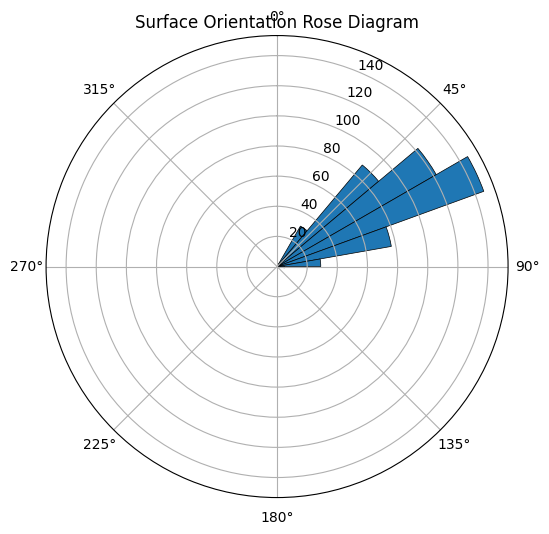

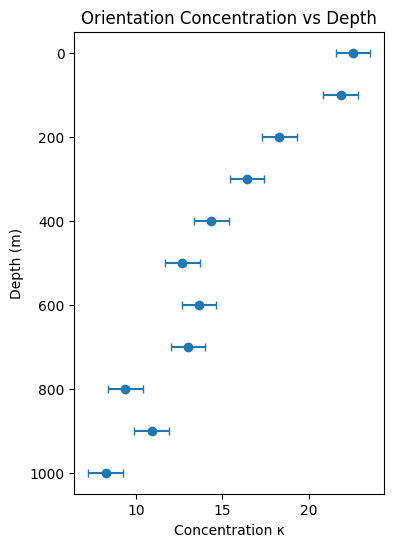

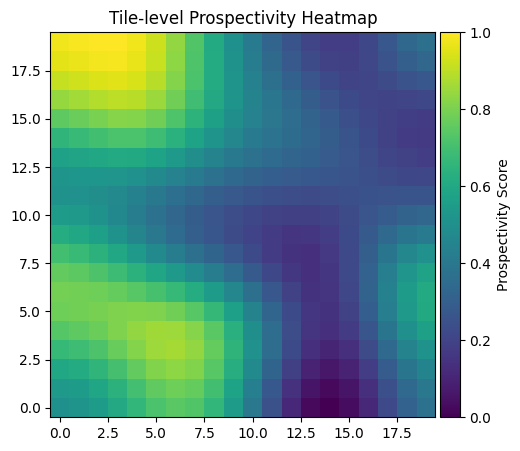

=== D–STEP Quick Summary ===
Files saved to: dstep_outputs_revised
• Rose diagram : dstep_outputs_revised/rose_diagram.png
• κ–depth plot : dstep_outputs_revised/kappa_depth.png
• Prospectivity heat‑map : dstep_outputs_revised/prospectivity_heatmap.png
• Tile score table : dstep_outputs_revised/tile_scores.csv

First 10 tile rankings by prospectivity:
 tile_id  grid_x  grid_y  prospectivity
     383      19       3       1.000000
     382      19       2       0.999559
     381      19       1       0.988695
     363      18       3       0.986812
     362      18       2       0.983062
     380      19       0       0.979631
     384      19       4       0.977092
     361      18       1       0.969122
     364      18       4       0.966853
     360      18       0       0.958164


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
import os

# ------------------------------------------------------------
# 0. Configuration
# ------------------------------------------------------------
np.random.seed(42)
output_dir = "dstep_outputs_revised"
os.makedirs(output_dir, exist_ok=True)

# ------------------------------------------------------------
# 1. Helper functions
# ------------------------------------------------------------
def sph2cart(az_deg, inc_deg):
    """Azimuth from North (clockwise), inclination positive downward."""
    az = np.deg2rad(az_deg)
    inc = np.deg2rad(inc_deg)
    return np.array([
        np.cos(inc) * np.cos(az),
        np.cos(inc) * np.sin(az),
        np.sin(inc)
    ])

def vmf_sample(mu, kappa, n):
    """Draw n samples from vMF on S^2 around mean direction mu."""
    dim = 3
    b = (-2 * kappa + np.sqrt(4 * kappa ** 2 + (dim - 1) ** 2)) / (dim - 1)
    x0 = (1 - b) / (1 + b)
    c = kappa * x0 + (dim - 1) * np.log(1 - x0 ** 2)

    def _rot_matrix(a, b):
        v = np.cross(a, b)
        s = np.linalg.norm(v)
        if s == 0:
            return np.eye(3)
        c_ab = np.dot(a, b)
        vx = np.array([[0, -v[2], v[1]],
                       [v[2], 0, -v[0]],
                       [-v[1], v[0], 0]])
        return np.eye(3) + vx + vx @ vx * ((1 - c_ab) / (s ** 2))

    rot = _rot_matrix(np.array([1.0, 0, 0]), mu)
    result = []

    while len(result) < n:
        z = np.random.beta((dim - 1) / 2, (dim - 1) / 2)
        w = (1 - (1 + b) * z) / (1 - (1 - b) * z)
        u = np.random.uniform()
        if kappa * w + (dim - 1) * np.log(1 - x0 * w) - c >= np.log(u):
            v = np.random.normal(size=(dim - 1,))
            v /= np.linalg.norm(v)
            sample = np.concatenate([[w], np.sqrt(1 - w ** 2) * v])
            result.append(rot @ sample)
    return np.vstack(result)

# ------------------------------------------------------------
# 2. Simulate surface orientation data
# ------------------------------------------------------------
n_surface = 500
mean_vec = sph2cart(60, 10)  # mean trend N60E, plunge 10°
surface_vectors = vmf_sample(mean_vec, kappa=20, n=n_surface)
surface_az = (np.degrees(np.arctan2(surface_vectors[:, 1],
                                    surface_vectors[:, 0])) + 360) % 360

# ------------------------------------------------------------
# 3. Depth‑varying κ profile (synthetic)
# ------------------------------------------------------------
depths = np.arange(0, 1001, 100)  # 0–1000 m
true_kappa = 20 * np.exp(-depths / 800) + 3
kappa_est = true_kappa + np.random.normal(0, 1, len(depths))
kappa_se = np.full(len(depths), 1.0)

# ------------------------------------------------------------
# 4. Tile‑level prospectivity grid
# ------------------------------------------------------------
grid_n = 20  # 20×20 → 400 tiles
raw_noise = np.random.rand(grid_n, grid_n)
prospectivity = gaussian_filter(raw_noise, sigma=3)
prospectivity = (prospectivity - prospectivity.min()) / (prospectivity.max() - prospectivity.min())

tile_df = pd.DataFrame({
    "tile_id": np.arange(grid_n ** 2),
    "grid_x": np.repeat(np.arange(grid_n), grid_n),
    "grid_y": np.tile(np.arange(grid_n), grid_n),
    "prospectivity": prospectivity.flatten()
})

# ------------------------------------------------------------
# 5. Plotting
# ------------------------------------------------------------

## 5a. Rose diagram
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection='polar')
bins = 36
theta = np.radians(surface_az)
counts, bin_edges = np.histogram(theta, bins=bins, range=(0, 2 * np.pi))
ax.bar(bin_edges[:-1], counts, width=2 * np.pi / bins,
       bottom=0, align='edge', edgecolor='k', linewidth=0.5)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
ax.set_title("Surface Orientation Rose Diagram")
rose_file = os.path.join(output_dir, "rose_diagram.png")
fig.savefig(rose_file, dpi=300, bbox_inches='tight')
plt.show()  # Shows rose diagram

plt.close(fig)

## 5b. κ vs depth
fig, ax = plt.subplots(figsize=(4, 6))
ax.errorbar(kappa_est, depths, xerr=kappa_se, fmt='o', capsize=3)
ax.set_ylabel("Depth (m)")
ax.set_xlabel("Concentration κ")
ax.set_title("Orientation Concentration vs Depth")
ax.invert_yaxis()
kappa_file = os.path.join(output_dir, "kappa_depth.png")
fig.savefig(kappa_file, dpi=300, bbox_inches='tight')
plt.show()  # Shows rose diagram

plt.close(fig)

## 5c. Prospectivity heat‑map
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(prospectivity, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax, label="Prospectivity Score")
ax.set_title("Tile‑level Prospectivity Heatmap")
heatmap_file = os.path.join(output_dir, "prospectivity_heatmap.png")
fig.savefig(heatmap_file, dpi=300, bbox_inches='tight')
plt.show()  # Shows rose diagram

plt.close(fig)

# ------------------------------------------------------------
# 6. Save table
# ------------------------------------------------------------
csv_file = os.path.join(output_dir, "tile_scores.csv")
tile_df.to_csv(csv_file, index=False)

# ------------------------------------------------------------
# 7. Console summary
# ------------------------------------------------------------
print("=== D–STEP Quick Summary ===")
print(f"Files saved to: {output_dir}")
print("• Rose diagram :", rose_file)
print("• κ–depth plot :", kappa_file)
print("• Prospectivity heat‑map :", heatmap_file)
print("• Tile score table :", csv_file)
print("\nFirst 10 tile rankings by prospectivity:")
print(tile_df.nlargest(10, 'prospectivity')[['tile_id', 'grid_x', 'grid_y', 'prospectivity']].to_string(index=False))
